# Dimentionality Reduction


# Introduction

In the previous lesson you learned about the different approaches for reducing the dimensionality of a dataset using different feature selection techniques. An alternative approach to feature selection for dimensionality reduction is **feature extraction**.

In this lesson, you will learn about three fundamental techniques that will help us to summarize the information content of a dataset by transforming it onto a new feature subspace of lower dimensionality than the original one. Data compression is an important topic in machine learning, and it helps us to store and analyze the increasing amounts of data that are produced and collected in the modern age of technology.

We will cover the following topics:

- **Principal Component Analysis** (**PCA**) for unsupervised data compression
- **Linear Discriminant Analysis** (**LDA**) as a supervised dimensionality reduction technique for maximizing class separability
- Nonlinear dimensionality reduction via **Kernel Principal Component Analysis** (**KPCA**)

# Principal Component Analysis

Similar to feature selection, we can use different feature extraction techniques to reduce the number of features in a dataset. The difference between feature selection and feature extraction is that while we maintain the original features when we used feature selection algorithms, such as **sequential backward selection**, we use feature extraction to transform or project the data onto a new feature space.

In the context of dimensionality reduction, feature extraction can be understood as an approach to data compression with the goal of maintaining most of the relevant information. In practice, feature extraction is not only used to improve storage space or the computational efficiency of the learning algorithm, but can also improve the predictive performance by reducing the **curse of dimensionality**—especially if we are working with non-regularized models.

### **The Main Steps Behind PCA**

In this step, we will discuss PCA, an unsupervised linear transformation technique that is widely used across different fields, most prominently for feature extraction and dimensionality reduction. Other popular applications of PCA include exploratory data analyses and de-noising of signals in stock market trading, and the analysis of genome data and gene expression levels in the field of bioinformatics.

PCA helps us to identify patterns in data based on the correlation between features. In a nutshell, PCA aims to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with equal or fewer dimensions than the original one. The orthogonal axes (principal components) of the new subspace can be interpreted as the directions of maximum variance given the constraint that the new feature axes are orthogonal to each other, as illustrated in the following figure

![iamg](https://cdn.filestackcontent.com/URUouEblQ3Gq36aXAGcK)

In the preceding figure, *x1* and *x2* are the original feature axes, and **PC1** and **PC2** are the principal components.

If we use PCA for dimensionality reduction, we construct a d \times k*d*×*k*–dimensional transformation matrix ***W*** that allows us to map a sample vector ***x*** onto a new *k*–dimensional feature subspace that has fewer dimensions than the original *d*–dimensional feature space:

$$dx=[x  1 ​	  ,x  2 ​	  ,…,x  d ​ ],  x∈R  d  \\ ↓xW,  W∈R  d×k \\ z=[z  1 ​	  ,z  2 ​	  ,…,z  k ​	  ],  z∈R  k$$

As a result of transforming the original *d*-dimensional data onto this new *k*-dimensional subspace (typically *k* << *d*), the first principal component will have the largest possible variance, and all consequent principal components will have the largest variance given the constraint that these components are uncorrelated (orthogonal) to the other principal components—even if the input features are correlated, the resulting principal components will be mutually orthogonal (uncorrelated).

Note that the PCA directions are highly sensitive to data scaling, and we need to standardize the features *prior* to PCA if the features were measured on different scales and we want to assign equal importance to all features.

Before looking at the PCA algorithm for dimensionality reduction in more detail, let's summarize the approach in a few simple steps:

1. Standardize the *d*-dimensional dataset.
2. Construct the covariance matrix.
3. Decompose the covariance matrix into its eigenvectors and eigenvalues.
4. Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
5. Select *k* eigenvectors which correspond to the *k* largest eigenvalues, where *k* is the dimensionality of the new feature subspace (*k*≤*d*).

    $$k \le d$$

6. Construct a projection matrix ***W*** from the "top" *k* eigenvectors.
7. Transform the *d*-dimensional input dataset ***X*** using the projection matrix ***W*** to obtain the new *k*-dimensional feature subspace.

Let’s perform a PCA step by step, using Python as a learning exercise. Then, we will see how to perform a PCA more conveniently using `scikit-learn`.

### **Extracting the Principal Components Step By Step**

In this subsection, we will tackle the first four steps of a PCA. Open the Jupyter notebook `dimensionality_reduction.ipynb` to get started!

First, we will start by loading the *Wine* dataset that we worked with in *Lesson 1*, *Data Preprocessing*:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from helper import plot_decision_regions
from rbf_kernel_pca import rbf_kernel_pca

In [4]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None);

In [5]:
df_wine.shape

(178, 14)

In [6]:
df_wine.head(6)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,1,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450


In [7]:
Y =  df_wine.iloc[:, 0].values
Y.shape

(178,)

In [8]:
X = df_wine.iloc[:, 1:].values
X.shape

(178, 13)

Next, we will process the *Wine* data into separate training and test sets—using a 70:30 split—and standardize it to unit variance:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y , test_size=0.3,
    stratify=Y, random_state=0
)

In [10]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

After completing the mandatory preprocessing, let's advance to the second step: constructing the covariance matrix. The symmetric $d \times d$-dimensional covariance matrix, where $d$ is the number of dimensions in the dataset, stores the pairwise covariances between the different features. For example, the covariance between two features $x_j$ and $x_k$ on the population level can be calculated via the following equation:

$$σ_{jk}​=\frac{1}{n}\sum_{i=1}^{n}​(x_j^{(i)}​−μ_j​)(x_k^{(i)}​−μ_k​)$$

Here,  $\mu_j$ and  $\mu_k$are the sample means of features *j* and *k*, respectively.

Note that the sample means are zero if we standardized the dataset. A positive covariance between two features indicates that the features increase or decrease together, whereas a negative covariance indicates that the features vary in opposite directions. For example, the covariance matrix of three features can then be written as follows (note that $\Sigma$ stands for the Greek uppercase letter **sigma**, which is not to be confused with the **sum** symbol):

$$\Sigma = \begin{bmatrix} \sigma_1^2 & \sigma_{12} & \sigma_{13} \\ \sigma_{21} & \sigma_2^2 & \sigma_{23} \\ \sigma_{31} & \sigma_{32} & \sigma_3^2 \end{bmatrix}$$

The eigenvectors of the covariance matrix represent the principal components (the directions of maximum variance), whereas the corresponding eigenvalues will define their magnitude. In the case of the *Wine* dataset, we would obtain 13 eigenvectors and eigenvalues from the 13 x 13-dimensional covariance matrix.

Now, for our third step, let's obtain the eigenpairs of the covariance matrix. As we remember from our introductory linear algebra classes, an eigenvector ***v*** satisfies the following condition:

$$Σv=λv$$

Here, $\lambda$ is a scalar: the eigenvalue. Since the manual computation of eigenvectors and eigenvalues is a somewhat tedious and elaborate task, we will use the `linalg.eig` function from `NumPy` to obtain the eigenpairs of the *Wine* covariance matrix:

In [11]:
cov_matrix = np.cov(X_train_std.T)
eig_values , eig_vectors = np.linalg.eig(cov_matrix)

print('Eigen Values \n',eig_values,'\n')
print('Eigen Vectors \n',eig_vectors,'\n')

Eigen Values 
 [4.84274532 2.41602459 1.54845825 0.96120438 0.84166161 0.6620634
 0.51828472 0.34650377 0.3131368  0.10754642 0.21357215 0.15362835
 0.1808613 ] 

Eigen Vectors 
 [[-1.37242175e-01  5.03034778e-01 -1.37748734e-01 -3.29610003e-03
  -2.90625226e-01  2.99096847e-01  7.90529293e-02 -3.68176414e-01
  -3.98377017e-01 -9.44869777e-02  3.74638877e-01 -1.27834515e-01
   2.62834263e-01]
 [ 2.47243265e-01  1.64871190e-01  9.61503863e-02  5.62646692e-01
   8.95378697e-02  6.27036396e-01 -2.74002014e-01 -1.25775752e-02
   1.10458230e-01  2.63652406e-02 -1.37405597e-01  8.06401578e-02
  -2.66769211e-01]
 [-2.54515927e-02  2.44564761e-01  6.77775667e-01 -1.08977111e-01
  -1.60834991e-01  3.89128239e-04  1.32328045e-01  1.77578177e-01
   3.82496856e-01  1.42747511e-01  4.61583035e-01  1.67924873e-02
  -1.15542548e-01]
 [ 2.06945084e-01 -1.13529045e-01  6.25040550e-01  3.38187002e-02
   5.15873402e-02 -4.05836452e-02  2.23999097e-01 -4.40592110e-01
  -2.43373853e-01 -1.30485780e-01 -4.1

Using the `numpy.cov` function, we computed the covariance matrix of the standardized training dataset. Using the `linalg.eig` function, we performed the eigen decomposition, which yielded a vector (`eigen_vals`) consisting of 13 eigenvalues and the corresponding eigenvectors stored as columns in a 13 x 13-dimensional matrix (`eigen_vecs`).

### **Total and Explained Variance**

Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the subset of the eigenvectors (principal components) that contains most of the information (variance). The eigenvalues define the magnitude of the eigenvectors, so we have to sort the eigenvalues by decreasing magnitude; we are interested in the top *k* eigenvectors based on the values of their corresponding eigenvalues.

But before we collect those *k* most informative eigenvectors, let us plot the **variance explained ratios** of the eigenvalues. The variance explained ratio of an eigenvalue $\lambda_j$​ is simply the fraction of an eigenvalue $\lambda_j$​ and the total sum of the eigenvalues:

$$\frac{\lambda_j}{\sum_{j=1}^d \lambda_j}$$

Using the `NumPy` `cumsum` function, we can then calculate the cumulative sum of explained variances, which we will then plot via `matplotlib`'s `step` function:

In [15]:
total = sum(eig_values)
sorted_evalues = sorted(eig_values,reverse=True)
print('sorted in Descending Order', sorted_evalues)
var_exp = [i/total for i in sorted_evalues]
cum_var_exp = np.cumsum(var_exp)

sorted in Descending Order [4.842745315655898, 2.4160245870352255, 1.5484582488203513, 0.9612043774977367, 0.8416616104578422, 0.6620634040383039, 0.5182847213561953, 0.34650376641286657, 0.3131368004720887, 0.2135721466052733, 0.18086130479496634, 0.15362835006711043, 0.10754642369670996]


 no  13 13


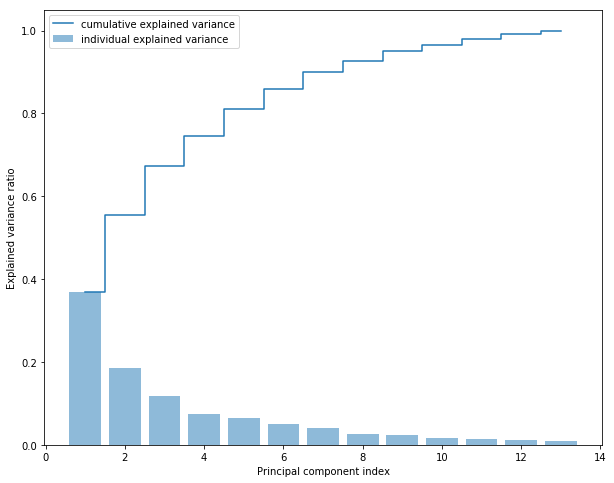

In [20]:
print('  ',len(var_exp) , len(cum_var_exp) )
# plot explained variances
plt.figure(figsize=(10, 8))
plt.bar(range(1,len(var_exp)+1), var_exp, alpha=0.5,
        align='center', label='individual explained variance')
plt.step(range(1,len(cum_var_exp)+1), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

The resulting plot indicates that the first principal component alone accounts for approximately 40% of the variance. Also, we can see that the first two principal components combined explain almost 60% of the variance in the dataset.

Although the explained variance plot reminds us of the feature importance values that we computed in *Lesson 1*, *Data Preprocessing*, via random forests, we should remind ourselves that PCA is an unsupervised method, which means that information about the class labels is ignored. Whereas a random forest uses the class membership information to compute the node impurities, variance measures the spread of values along a feature axis.

### **Feature Transformation**

After we have successfully decomposed the covariance matrix into eigenpairs, let's now proceed with the last three steps to transform the *Wine* dataset onto the new principal component axes. The remaining steps we are going to tackle in this section are the following ones:

- Select *k* eigenvectors, which correspond to the *k* largest eigenvalues, where *k* is the dimensionality of the new feature subspace (*k*≤*d*).

    $$k \le d$$

- Construct a projection matrix ***W*** from the "top" *k* eigenvectors.
- Transform the *d*-dimensional input dataset ***X*** using the projection matrix ***W*** to obtain the new *k*-dimensional feature subspace.

Or, in less technical terms, we will sort the eigenpairs by descending order of the eigenvalues, construct a projection matrix from the selected eigenvectors, and use the projection matrix to transform the data onto the lower-dimensional subspace.

We start by sorting the eigenpairs by decreasing order of the eigenvalues: